In [1]:
# Importing the libraries

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn, optim
from torchvision import datasets as d, transforms as t, models
from torch.utils.data import DataLoader
import timm
import csv
import random
import seaborn as sns

In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
# Apply the transformations on the data and build the dataloaders

batch_size = 32

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transforms = {
    'train': t.Compose([t.RandomHorizontalFlip(),
                        t.RandomResizedCrop(224),
                        t.RandomRotation(10),
                        t.ToTensor(),
                        t.Normalize(mean, std)]),
    'val_test': t.Compose([t.Resize(255),
                           t.CenterCrop(224),
                           t.ToTensor(),
                           t.Normalize(mean, std)])
}

datasets = {
    'train': d.ImageFolder('model_images/train', transform=transforms['train']),
    'valid': d.ImageFolder('model_images/valid', transform=transforms['val_test']),
    'test': d.ImageFolder('model_images/test', transform=transforms['val_test'])
}

dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),
    'valid': DataLoader(datasets['valid'], batch_size=batch_size),
    'test': DataLoader(datasets['test'], batch_size=batch_size)
}

In [4]:
# Function to show the images

def imshow(image, ax=None):
    image = image.numpy().transpose((1, 2, 0))
    image = image * std + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image) if ax else plt.imshow(image)

(torch.Size([3, 224, 224]), torch.Size([32]))

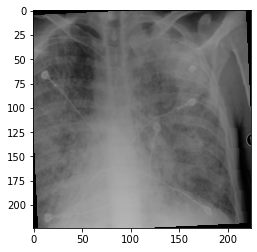

In [5]:
img, _ = next(iter(dataloaders['train']))
imshow(img[0])
img[0].shape,_.shape

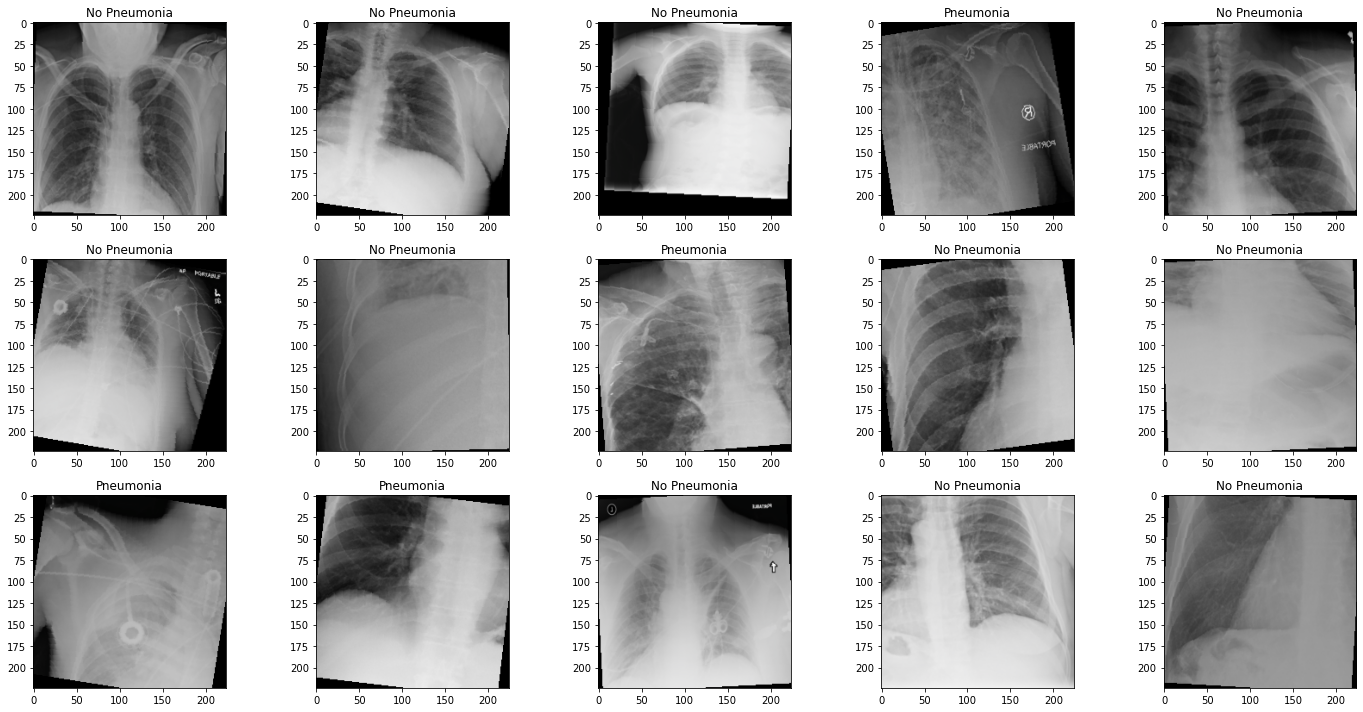

In [6]:
# Showing some images for each class

classes = datasets['train'].classes
images, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    imshow(images[i], ax)
    ax.set_title('Pneumonia' if int(classes[labels[i]]) else 'No Pneumonia')

plt.tight_layout()

### Initialize use_cuda variable

In [7]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [8]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """
    function to train and validate the model
    args:
        n_epochs (int): number of epochs to train the model
        loaders (dict): dictionary containing training, validation, and test data loaders
        model: model to train
        optimizer: optimizer to use for training
        criterion: loss function to use
        use_cuda (bool): flag for whether to use cuda
        save_path (str): path to save the model to
    return:
        model: trained model
        losses: list of training and validation losses for each epoch
    """

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    losses = np.zeros((n_epochs,2))

    for epoch in range(n_epochs):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for data, target in loaders['train']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda().unsqueeze(1).float()

            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, target)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        ######################
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for data, target in loaders['valid']:
            with torch.no_grad():
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda().unsqueeze(1).float()

                val_out = model(data)
                loss = criterion(val_out, target)
                valid_loss += loss.item()

        train_loss /= len(loaders['train'])
        valid_loss /= len(loaders['valid'])
        losses[epoch] = (train_loss,valid_loss)

        # print training/validation statistics
        print(
            f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ... Model saved ...')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)

    return model, losses, valid_loss_min

In [9]:
def test(test_loader, model, criterion, use_cuda):
    """
    function to test the model
    args:
        test_loader (dict): dictionary containing the test data loader
        model: model to test
        criterion: loss function to use
        use_cuda (bool): flag for whether to use cuda
    return:
        test_loss: test loss
        y_pred (numpy array): predictions
        y_true (numpy array): ground truth
    """

    # monitor test loss and accuracy
    test_loss = 0.
    y_true = np.array([])
    y_pred = np.array([])

    # set the module to evaluation mode
    model.eval()

    for data, target in test_loader:
        # move to GPU
        with torch.no_grad():
            if use_cuda:
                data, target = data.cuda(), target.cuda().unsqueeze(1).float()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss
            test_loss += loss.item()

            output = torch.sigmoid(output)
            y_true = np.append(y_true, target.cpu().numpy())
            y_pred = np.append(y_pred, output.cpu().numpy())

    test_loss /= len(test_loader)

    print(f'Test Loss: {test_loss:.6f}\n')

    return test_loss, y_true, y_pred

In [10]:
def store_model_info(file_path, model_name, optimizer_name, lr, min_valid_loss, test_loss):
    with open(file_path, 'a') as f:
        row = [model_name, optimizer_name, lr, min_valid_loss, test_loss]
        # create the csv writer
        writer = csv.writer(f)

        # write a row to the csv file
        writer.writerow(row)

In [11]:
def create_model(model_name):
    model = timm.create_model(model_name, pretrained=True)
    try:
        model.classifier = nn.Sequential(nn.Linear(model.classifier.in_features, 128, bias=False),
                                         nn.BatchNorm1d(128),
                                         nn.ReLU(),
                                         nn.Dropout(0.25),
                                         nn.Linear(128, 1))
    except:
        model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 128, bias=False),
                                 nn.BatchNorm1d(128),
                                 nn.ReLU(),
                                 nn.Dropout(0.25),
                                 nn.Linear(128, 1))
    return model


model_name = 'efficientnet_b1'
model = create_model(model_name)
lr = 0.00005
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, amsgrad=True, weight_decay=0.0001)


In [12]:
if use_cuda:
    model = model.cuda()

epochs = 35
model, losses, min_valid_loss = train(epochs, dataloaders, model, optimizer, criterion, use_cuda, f'../results/{model_name}-model.pt')

Epoch: 1 	Training Loss: 0.598272 	Validation Loss: 0.506993
Validation loss decreased ... Model saved ...
Epoch: 2 	Training Loss: 0.518627 	Validation Loss: 0.394038
Validation loss decreased ... Model saved ...
Epoch: 3 	Training Loss: 0.499045 	Validation Loss: 0.409228
Epoch: 4 	Training Loss: 0.464882 	Validation Loss: 0.340861
Validation loss decreased ... Model saved ...
Epoch: 5 	Training Loss: 0.458292 	Validation Loss: 0.386777
Epoch: 6 	Training Loss: 0.463339 	Validation Loss: 0.435836
Epoch: 7 	Training Loss: 0.431752 	Validation Loss: 0.425515
Epoch: 8 	Training Loss: 0.435656 	Validation Loss: 0.513034
Epoch: 9 	Training Loss: 0.411496 	Validation Loss: 0.393944
Epoch: 10 	Training Loss: 0.411574 	Validation Loss: 0.437463
Epoch: 11 	Training Loss: 0.396248 	Validation Loss: 0.343014
Epoch: 12 	Training Loss: 0.400419 	Validation Loss: 0.341007
Epoch: 13 	Training Loss: 0.382448 	Validation Loss: 0.487687
Epoch: 14 	Training Loss: 0.379869 	Validation Loss: 0.360674
Epo

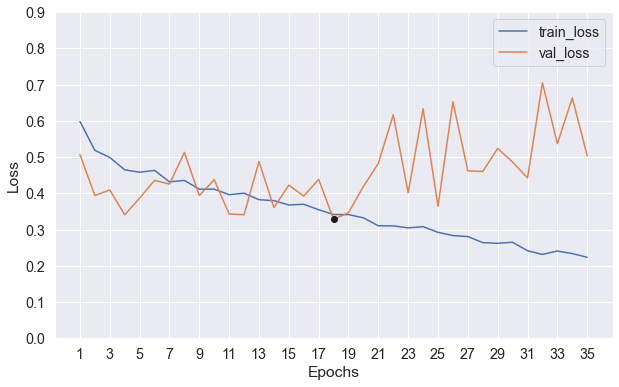

In [13]:
def plot_losses(losses):
    """
    function to plot training and validation losses
    args:
        losses (np array): array containing training and validation losses for each epoch
    """

    _, ax = plt.subplots(figsize=(10,6))
    ax.set(xlabel='Epochs', ylabel='Loss')
    ax.plot(range(1, epochs+1), losses[:, 0], label='train_loss')
    ax.plot(range(1,epochs+1), losses[:, 1], label='val_loss')
    ax.plot(np.argmin(losses[:, 1])+1, np.min(losses[:, 1]), marker='o', color='k', markersize=6) 
    ax.set_xticks(range(1, epochs+1, 2))
    ax.set_yticks(np.arange(0, np.max(losses[:, 1])+0.2, 0.1))
    ax.legend()

sns.set_theme(font_scale=1.3)
plot_losses(losses)  

In [14]:
model.load_state_dict(torch.load(f'../results/{model_name}-model.pt'))

<All keys matched successfully>

In [15]:
if use_cuda:
    model = model.cuda()
    
test_loss, y_true, y_pred = test(dataloaders["test"], model, criterion, use_cuda)

Test Loss: 0.337797



In [16]:
store_model_info('../results/try.csv', model_name, optimizer.__class__.__name__, lr, min_valid_loss, test_loss)

In [17]:
# Graphs functions

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix


def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    fpr, tpr, threshold = roc_curve(t_y, p_y)
    ax.plot(fpr, tpr, label='%s (AUC:%.2f)' % ('Pneumonia', auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Chance', alpha=.8)
    ax.legend()
    ax.set_xlabel('1 - Spicifity')
    ax.set_ylabel('Sensitivity')


def pr_curve(ground_truth, probability):
    
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    precision, recall, threshold = precision_recall_curve(ground_truth, probability)
    ax.plot(recall, precision, label='%s (AP Score:%.2f)' % ('Pneumonia', average_precision_score(ground_truth, probability)))
    ax.legend()
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')


def cal_F1Score(precision, recall):
    f1_score = 2*(precision * recall)/(precision + recall)
    return f1_score


def plot_f1_score(valY, pred_Y):
    
    precision, recall, threshold = precision_recall_curve(valY, pred_Y)
    f1_scores = [cal_F1Score(precision[i], recall[i]) for i in range(len(threshold))]
    max_f1_score_idx = np.argmax(f1_scores)
    
    print('Max F1 Score and corresponding Precision, recall and Threshold\n')
    print('Precision: '+ str(precision[max_f1_score_idx]))
    print('Recall: '+ str(recall[max_f1_score_idx]))
    print('Threshold: '+ str(threshold[max_f1_score_idx]))
    print('F1 Score: ' + str(f1_scores[max_f1_score_idx]))
    
    plt.figure()
    plt.plot(threshold, f1_scores)
    plt.title("F1-Score vs Threshold")
    plt.xlabel("Epoch Number")
    plt.ylabel("F1-Score")
    plt.show()
    return threshold[max_f1_score_idx]

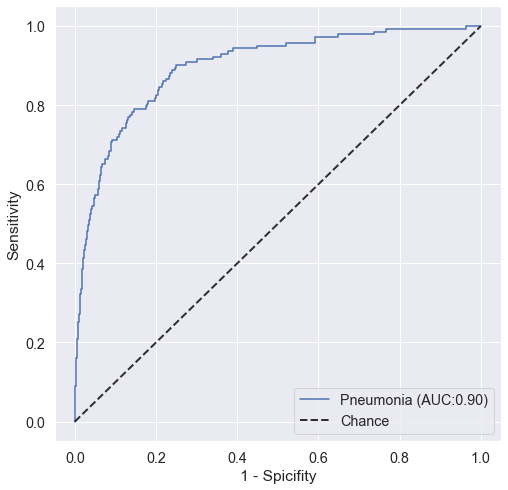

In [18]:
plot_auc(y_true, y_pred)

In [28]:
def calculate_statistics(target, pred, threshold):
    """
    function to calculate statistics like accuracy, sensetivity(recall), specificity, precision, , f1-score
    args:
        target (np array): array containing true labels
        pred (np array): array containing predicted labels
        threshold (float): threshold value
    """

    target, pred = torch.from_numpy(target), torch.from_numpy(pred)
    
    # convert output probabilities to predicted class
    pred = (torch.sigmoid(pred) > threshold).to(torch.float32)

    tp = (target * pred).sum()
    tn = ((1 - target) * (1 - pred)).sum().to(torch.float32)
    fp = ((1 - target) * pred).sum().to(torch.float32)
    fn = (target * (1 - pred)).sum().to(torch.float32)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1_score = 2 * (sensitivity * precision) / (sensitivity + precision)

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * (tp + tn) / (tp + tn + fp + fn), (tp + tn), (tp + tn + fp + fn)))
    print(f'sensitivity = {sensitivity}')
    print(f'recall = {sensitivity}')
    print(f'specifity = {specificity}')
    print(f"tp={tp}, fn={fn}, tn={tn}, fp={fp}")


In [34]:
calculate_statistics(y_true, y_pred, 0.58)


Test Accuracy: 80% (2510/3123)
sensitivity = 0.8181818181818182
recall = 0.8181818181818182
specifity = 0.8030201196670532
tp=117.0, fn=26.0, tn=2393.0, fp=587.0


In [27]:
def predict(model_name, model_path, img_path):
    with torch.no_grad():
        img = transforms['val_test'](Image.open(
            img_path).convert('RGB')).unsqueeze(0)

        model = create_model(model_name)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        preds = torch.sigmoid(model.forward(img))
        return preds


# test on a sample image
print(predict(model_name, f"../results/{model_name}-model.pt", '.\\model_images\\test\\0\\00000012_000.png'))
print(predict(model_name, f"../results/{model_name}-model.pt", '.\\model_images\\test\\1\\00006991_010.png'))


tensor([[0.1117]])
tensor([[0.9132]])
